## Web Scraping

Using Web Scraping we will obtain information about the history of names of streets of Barcelona 

In [1]:
# Importing libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

First, we will get the codes of the streets of Barcelona from a csv file downloaded from the opendata service 
from Ajuntamento de Barcelona



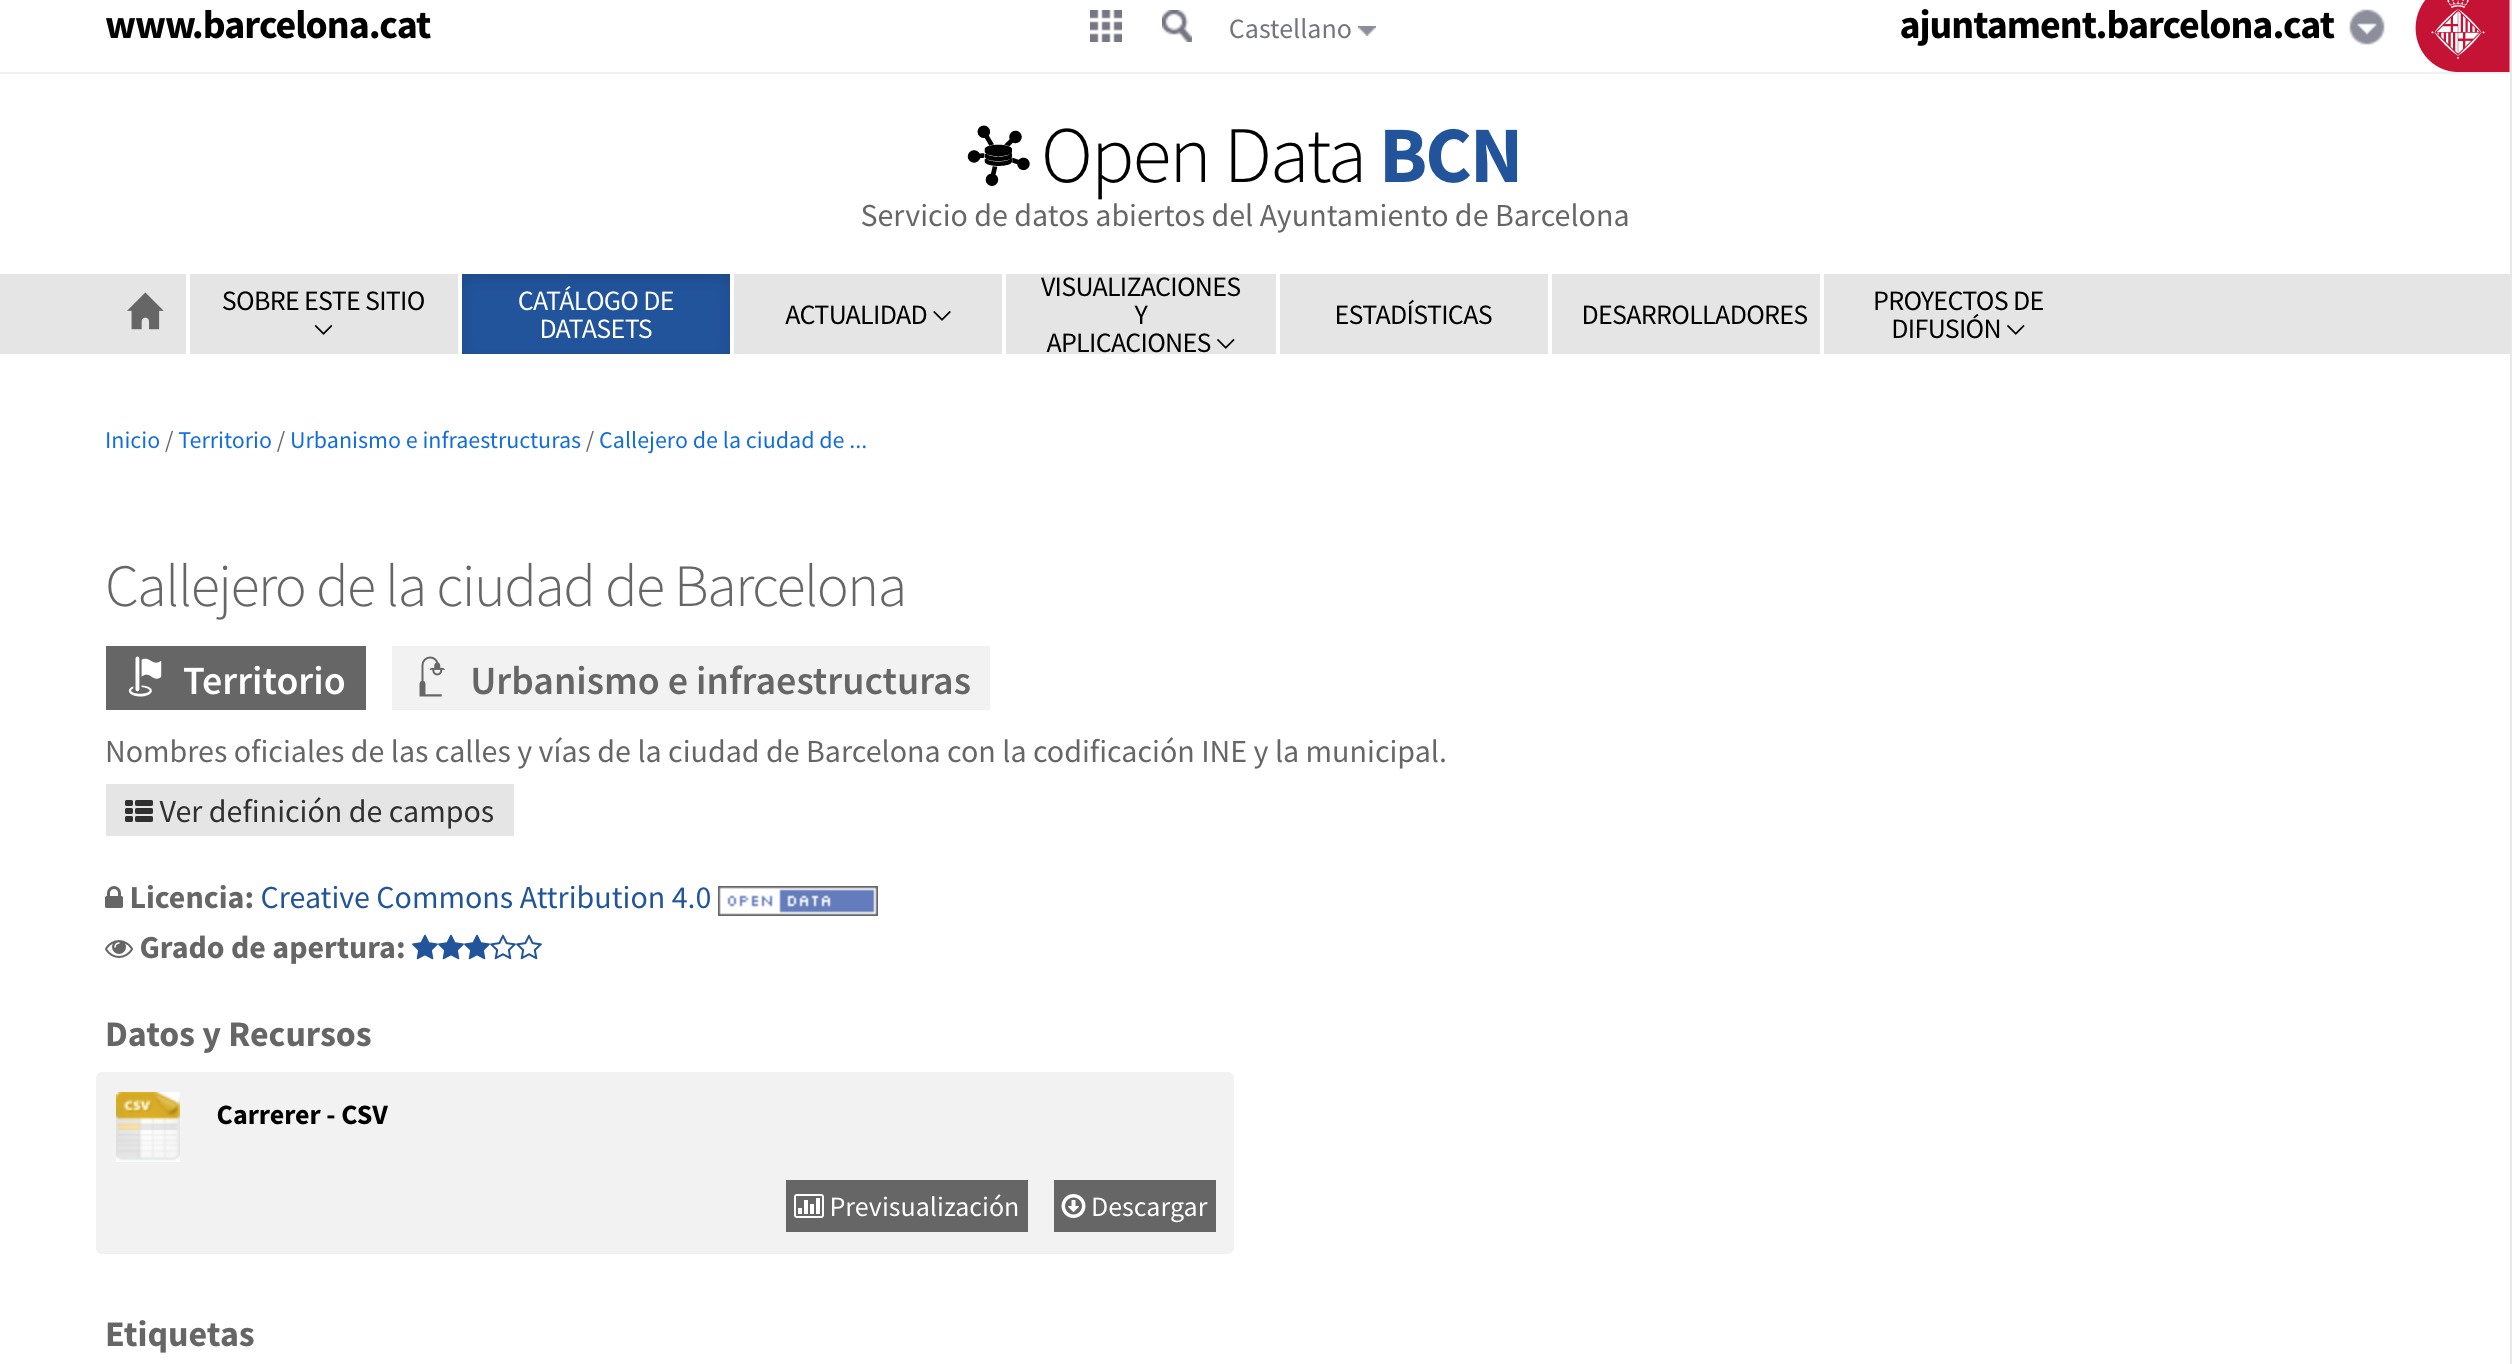

In [2]:
street_info = urlopen("http://opendata-ajuntament.barcelona.cat/data/dataset/d7802fd1-cdfb-4562-9148-d18722d7e2d8/resource/2b010e59-6952-4b27-9c4e-47fcaf64c916/download")
with open('CARRERER.csv','wb') as output:
    output.write(street_info.read())


In [3]:
# Converting the CSV data to a pandas dataframe

street_codes_df = pd.read_csv("CARRERER.csv", encoding="utf8") 
street_codes_df.head()

,CODI_VIA,CODI_CARRER_INE,TIPUS_VIA,NOM_OFICIAL,NOM_CURT,NRE_MIN,NRE_MAX
0,102,1,C,Carrer dels Llebrencs,Llebrencs,NaN,NaN
1,180,2,C,Carrer A Zona Franca,A Zona Franca,NaN,NaN
2,204,3,C,Carrer de Guerau de Liost,Guerau de Liost,NaN,NaN
3,306,4,C,Carrer de l'Abat Odó,Abat Odó,NaN,NaN
4,408,5,C,Carrer de l'Abat Samsó,Abat Samsó,NaN,NaN


In [4]:
# Selecting the columns we are interested in: 

street_codes_df = street_codes_df.iloc[:, [0, 2, 3, 4]]
street_codes_df.head()

,CODI_VIA,TIPUS_VIA,NOM_OFICIAL,NOM_CURT
0,102,C,Carrer dels Llebrencs,Llebrencs
1,180,C,Carrer A Zona Franca,A Zona Franca
2,204,C,Carrer de Guerau de Liost,Guerau de Liost
3,306,C,Carrer de l'Abat Odó,Abat Odó
4,408,C,Carrer de l'Abat Samsó,Abat Samsó


#### url = "http://w10.bcn.cat/APPS/nomenclator/ficha.do?codic=" + formated_code + "&idioma=1"

#### Example: "http://w10.bcn.cat/APPS/nomenclator/ficha.do?codic=029400&idioma=1"

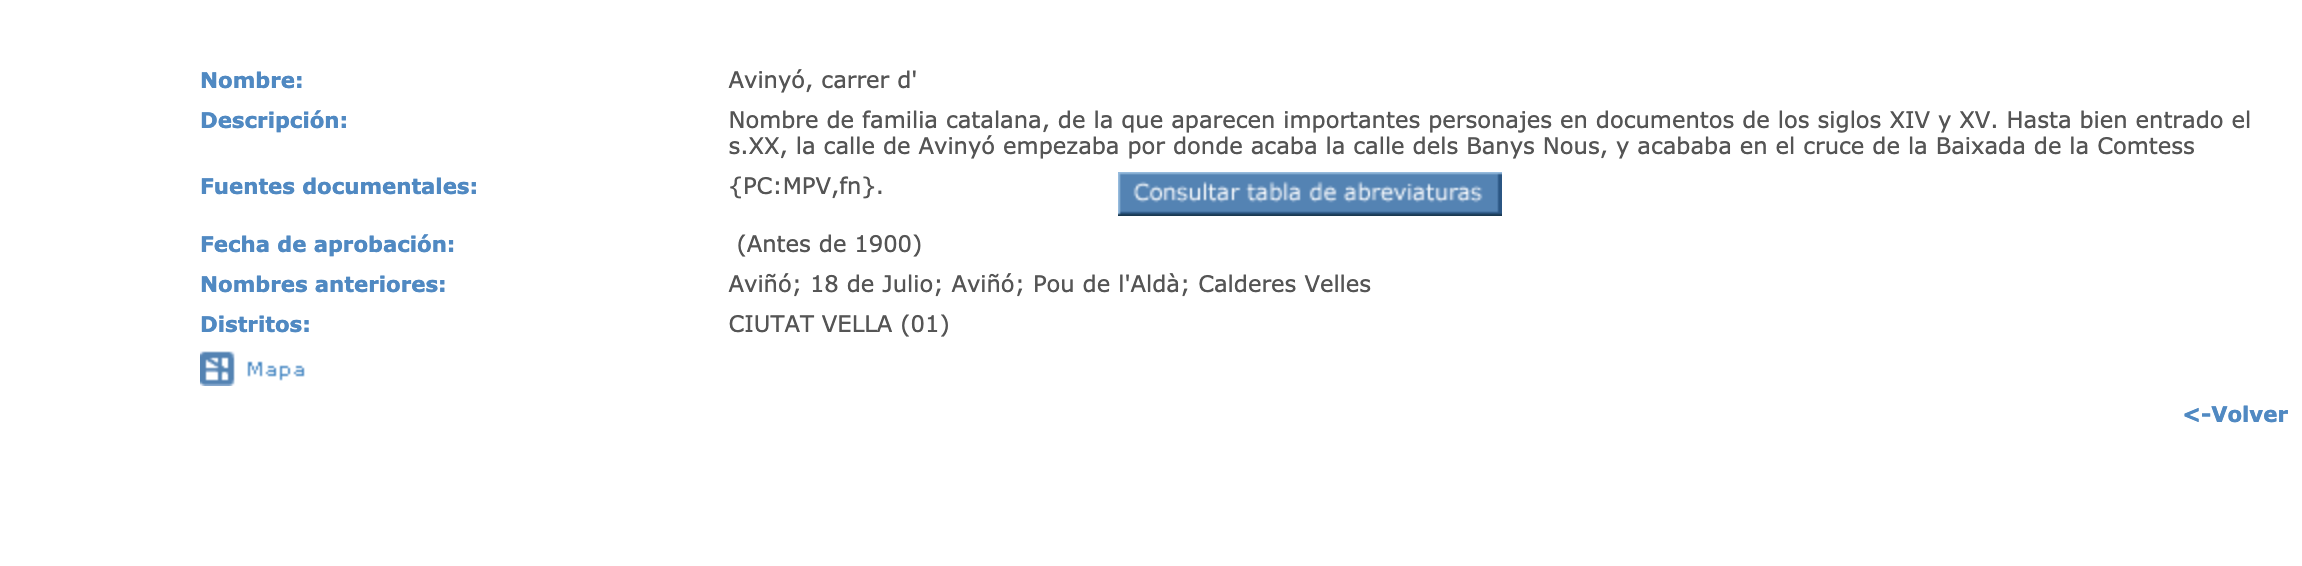

In [6]:
%%time
streets = []
for index, row in street_codes_df.iterrows():
    
    # The street codes must have 6 digits, adding zeroes to the left if necessary
    code = str(row['CODI_VIA'])   
    formated_code = ("00000" + code)[-6:]
    
    url = "http://w10.bcn.cat/APPS/nomenclator/ficha.do?codic=" + formated_code + "&idioma=1"
    
    # Scrapping the web
    try:
        html = urlopen(url)
        soup = BeautifulSoup(html)
        tags_list = soup.findAll("td", {"class":"textonoticia"})
        text_list = [tag.get_text() for tag in tags_list] 
        
        new_street = []
        new_street.append(code)
        
        description = text_list[1]
        new_street.append(description)
        
        aproving_date = text_list[3]
        new_street.append(aproving_date)
        
        former_names = text_list[4]
        new_street.append(former_names)
        
        districts = text_list[5].strip()
        new_street.append(districts)
        
        streets.append(new_street)
    except:
        pass

CPU times: user 1min 53s, sys: 2.33 s, total: 1min 56s
Wall time: 9min 53s


In [7]:
streets

[['102',
  'Nombre popular que se da a los nacidos en Vallvidrera, por la forma de caminar que se parece a la de las liebres.',
  '29/06/1987\xa0( )',
  'Lletra A (Vallvidrera)',
  'SARRIÀ-SANT GERVASI (05)'],
 ['180',
  'Esta calle es una de las más importantes de la zona. La Comisión de Urbanismo aprobó el Plan parcial de ordenación del polígono industrial del Consorcio de la Zona Franca de Barcelona, en el que, con alguna excepción, las calles designadas con letras siguen la dirección norte-sur y las designadas con números la dirección este-oeste.',
  '16/02/1968\xa0( )',
  '',
  'SANTS-MONTJUÏC (03)'],
 ['204',
  'Seudónimo literario con el que se conoce al poeta catalán Jaume Bofill i Mates (Olot, La Garrotxa 1878 - Barcelona 1933). Poeta, político y periodista.',
  '29/07/1987\xa0( )',
  'Ptge. lletra A (Vallvidrera)',
  'SARRIÀ-SANT GERVASI (05)'],
 ['306',
  'Abad del monasterio de Sant Cugat del Vallès desde el año 986 hasta el 1010. Obispo de Girona. La incursión de Al-Mansur

In [8]:
# Creating a new dataframe from the info obtained 

labels = ['CÓDIGO', 'DESCRIPCION', 'FECHA_APROBACION', 'NOMBRES_ANTERIORES', 'DISTRICTOS']         
streets_df = pd.DataFrame.from_records(streets, columns=labels)
streets_df.head()

,CÓDIGO,DESCRIPCION,FECHA_APROBACION,NOMBRES_ANTERIORES,DISTRICTOS
0,102,Nombre popular que se da a los nacidos en Vall...,29/06/1987 ( ),Lletra A (Vallvidrera),SARRIÀ-SANT GERVASI (05)
1,180,Esta calle es una de las más importantes de la...,16/02/1968 ( ),,SANTS-MONTJUÏC (03)
2,204,Seudónimo literario con el que se conoce al po...,29/07/1987 ( ),Ptge. lletra A (Vallvidrera),SARRIÀ-SANT GERVASI (05)
3,306,Abad del monasterio de Sant Cugat del Vallès d...,,"Otto, 1939; Abat Odó, 1934; Otto, 1907; Santa ...",SANT ANDREU (09)
4,408,"Según unas fuentes, Bernat Samsó (siglo XV) in...",07/03/1939 ( ),"Bernat Cavaller, 1931; Abat Samsó, 1927; Berna...",SARRIÀ-SANT GERVASI (05)


In [9]:
# Creating a new dataframe that concatenates information from the two dataframes 

street_info_df = pd.concat([street_codes_df, streets_df], axis=1)
street_info_df = street_info_df.iloc[:, [0, 1, 2, 3, 5, 6, 7, 8]]
street_info_df.head()

,CODI_VIA,TIPUS_VIA,NOM_OFICIAL,NOM_CURT,DESCRIPCION,FECHA_APROBACION,NOMBRES_ANTERIORES,DISTRICTOS
0,102,C,Carrer dels Llebrencs,Llebrencs,Nombre popular que se da a los nacidos en Vall...,29/06/1987 ( ),Lletra A (Vallvidrera),SARRIÀ-SANT GERVASI (05)
1,180,C,Carrer A Zona Franca,A Zona Franca,Esta calle es una de las más importantes de la...,16/02/1968 ( ),,SANTS-MONTJUÏC (03)
2,204,C,Carrer de Guerau de Liost,Guerau de Liost,Seudónimo literario con el que se conoce al po...,29/07/1987 ( ),Ptge. lletra A (Vallvidrera),SARRIÀ-SANT GERVASI (05)
3,306,C,Carrer de l'Abat Odó,Abat Odó,Abad del monasterio de Sant Cugat del Vallès d...,,"Otto, 1939; Abat Odó, 1934; Otto, 1907; Santa ...",SANT ANDREU (09)
4,408,C,Carrer de l'Abat Samsó,Abat Samsó,"Según unas fuentes, Bernat Samsó (siglo XV) in...",07/03/1939 ( ),"Bernat Cavaller, 1931; Abat Samsó, 1927; Berna...",SARRIÀ-SANT GERVASI (05)


In [10]:
# Saving the data from the dataframe into a CSV file
street_info_df.to_csv('BCN_nomenclator.csv', sep='\t', encoding='utf-8')